In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np
import pandas as pd
import seaborn as sns

plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['grid.color'] = '#505F69'
sns.set_style("whitegrid")

In [2]:
# read data
cdc = pd.read_csv('cdc.csv', skiprows=2)

# rename some CDC columns
cdc.rename(columns={
    'abbr': 'state',
    'Total Cases': 'cdc_total_cases',
    'Total Death': 'cdc_total_death',
    'CasesInLast7Days': 'cdc_cases_last_7_days',
    'RatePer100000': 'cdc_rate_per_100000',
    'Total Tests Performed': 'cdc_total_tests',
    'Percent Positive Range': 'cdc_percent_positive_range',
    'cumulative_positive_tests': 'cdc_cumulative_positive_tests'
}, inplace=True)

In [3]:
# Use CTP 5/14 for comparing test counts

ctp_514_tests = pd.read_csv('ctp_514.csv')
ctp_514_test_overrides = pd.read_csv('ctp_514_specimen_tests.csv')

ctp_514_merged_df = pd.merge(
    ctp_514_tests, ctp_514_test_overrides, on=['state', 'date'], how='inner', sort=True, copy=True)

def pick_total_tests_for_analysis(row):
    # prioritize if present: specimens, people, unclear source
    if not pd.isnull(row.total_tests_specimens):
        return row.total_tests_specimens
    elif not pd.isnull(row.total_tests_people):
        return row.total_tests_people
    else:
        return row.total_tests_unclear

ctp_514_merged_df['ctp_total_tests_for_analysis'] = ctp_514_merged_df.apply(pick_total_tests_for_analysis, axis=1)

# merge with CTP reported data - only keeping rows for which both CDC and CTP report data
merged_df_test_counts = pd.merge(
    cdc, ctp_514_merged_df, on=['state', 'fips'], how='inner', sort=True, copy=True)

# of this, keep only some interesting columns:
# state, jurisdiction, cdc_total_cases, cdc_total_death, cdc_total_tests
cols_to_keep = ['state', 'jurisdiction', 'cdc_total_cases', 'cdc_total_death', 'cdc_total_tests',
               'ctp_total_tests_for_analysis']
merged_df_test_counts = merged_df_test_counts[cols_to_keep]
merged_df_test_counts.head()

,state,jurisdiction,cdc_total_cases,cdc_total_death,cdc_total_tests,ctp_total_tests_for_analysis
0,AK,Alaska,388,10,46589.0,31762.0
1,AL,Alabama,11642,484,168687.0,141985.0
2,AR,Arkansas,4463,98,84496.0,75818.0
3,AZ,Arizona,13169,651,210388.0,134338.0
4,CA,California,74936,3108,924696.0,1104651.0


In [4]:
# will use CTP 5/16 for comparing positives/deaths
ctp_516_positives_deaths = pd.read_csv('ctp_516.csv')
cols_to_keep = ['state', 'positive', 'death']
ctp_516_positives_deaths = ctp_516_positives_deaths[cols_to_keep]
ctp_516_positives_deaths.head()

,state,positive,death
0,AK,392.0,10.0
1,AL,11523.0,485.0
2,AR,4578.0,98.0
3,AZ,13631.0,679.0
4,CA,76793.0,3204.0


# Make a minimal dataframe for analysis containing only final columns

In [5]:
full_merged_df = pd.merge(
    merged_df_test_counts, ctp_516_positives_deaths, on=['state'], how='inner', sort=True, copy=True)
# rename some CDC columns
full_merged_df.rename(columns={
    'positive': 'ctp_total_cases',
    'death': 'ctp_total_death',
}, inplace=True)
full_merged_df.set_index('state', inplace=True)
full_merged_df.to_csv('merged_data_for_analysis.csv')

# How many nationwide tests according to CDC and CTP? What are the national positivity rates?

In [6]:
# CTP
print('CTP:')
ctp_us_positives = sum(full_merged_df.ctp_total_cases)
ctp_us_tests = sum(full_merged_df.ctp_total_tests_for_analysis)
print('National positives: %d' % ctp_us_positives)
print('National test count: %d' % ctp_us_tests)
print('National positivity rate: %s' % float(ctp_us_positives/ctp_us_tests))

# same for CDC
print('CDC:')
cdc_us_positives = sum(full_merged_df.cdc_total_cases)
cdc_us_tests = sum(full_merged_df.cdc_total_tests)
print('National positives: %d' % cdc_us_positives)
print('National test count: %d' % cdc_us_tests)
print('National positivity rate: %s' % float(cdc_us_positives/cdc_us_tests))

CTP:
National positives: 1455954
National test count: 10462017
National positivity rate: 0.13916570772156076
CDC:
National positives: 1432265
National test count: 10831698
National positivity rate: 0.1322290374048464


In [7]:
full_merged_df['test_count_diff'] = \
    full_merged_df['cdc_total_tests'] - full_merged_df['ctp_total_tests_for_analysis']
full_merged_df['abs_test_count_diff'] = \
    abs(full_merged_df['cdc_total_tests'] - full_merged_df['ctp_total_tests_for_analysis'])
full_merged_df['test_count_percent_diff'] = \
    full_merged_df['test_count_diff']/full_merged_df['ctp_total_tests_for_analysis']
full_merged_df['abs_test_count_percent_diff'] = \
    abs(full_merged_df['test_count_diff']/full_merged_df['ctp_total_tests_for_analysis'])
# sort by test_count_diff
full_merged_df.sort_values('test_count_diff', inplace=True)

In [8]:
full_merged_df.head()

,jurisdiction,cdc_total_cases,cdc_total_death,cdc_total_tests,ctp_total_tests_for_analysis,ctp_total_cases,ctp_total_death,test_count_diff,abs_test_count_diff,test_count_percent_diff,abs_test_count_percent_diff
state,,,,,,,,,,,
CA,California,74936,3108,924696.0,1104651.0,76793.0,3204.0,-179955.0,179955.0,-0.162907,0.162907
TX,Texas,45198,1272,454133.0,623284.0,46999.0,1305.0,-169151.0,169151.0,-0.271387,0.271387
NC,North Carolina,17129,641,151449.0,219268.0,17982.0,652.0,-67819.0,67819.0,-0.309297,0.309297
NJ,New Jersey,143905,10138,409320.0,451696.0,145089.0,10249.0,-42376.0,42376.0,-0.093815,0.093815
IL,Illinois,90369,4058,470698.0,512037.0,92457.0,4129.0,-41339.0,41339.0,-0.080734,0.080734


In [9]:
# sns.set_style("whitegrid")

# plt.figure(figsize=(18,7))

# def get_color(row):
#     if row.test_count_diff > 0:
#         return '#ffad4a'
#     else:
#         return '#585bc1'
    
# palette = list(full_merged_df.apply(get_color, axis=1))
# ax = sns.barplot(x=full_merged_df.index, y='test_count_diff', data=full_merged_df,
#                  palette=palette)
# ax.set_xticklabels(rotation=45, labels=full_merged_df.index, fontsize=12)
# ax.set_ylabel('')
# ax.set_xlabel('')
# ax.set_title('Test count differences between CDC and CTP data', fontsize=20, pad=10)


# Test count comparison CTP vs CDC

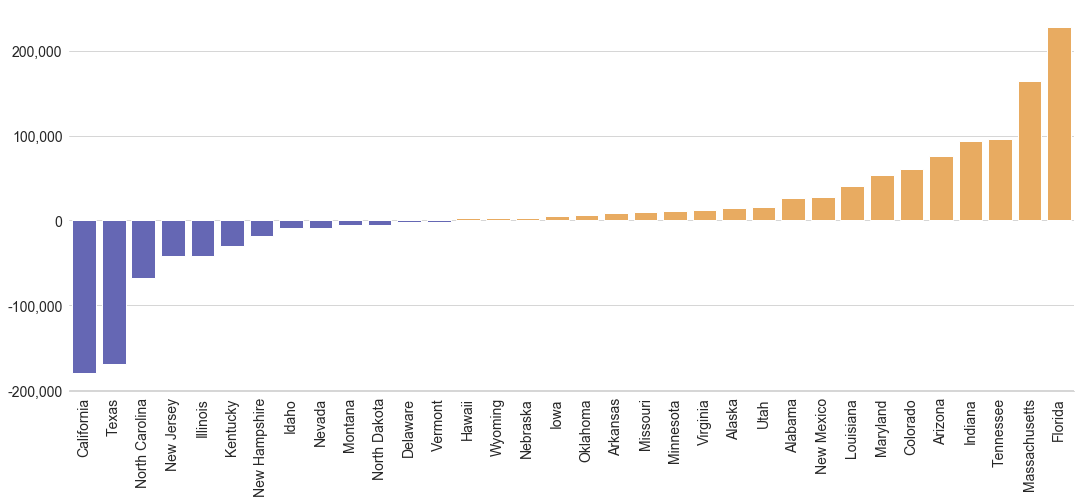

In [10]:
# a bit too busy, let's pick a difference threshold - only show states with a >5% difference
sns.set_style("whitegrid")

plt.figure(figsize=(18,7))

def get_color(row):
    if row.test_count_diff > 0:
        return '#ffad4a'  # orange
    else:
        return '#585bc1'  # purple

data = full_merged_df.loc[full_merged_df.abs_test_count_percent_diff > 0.05]
palette = list(data.apply(get_color, axis=1))

ax = sns.barplot(x=data.index, y='test_count_diff', data=data, palette=palette)
sns.despine(ax=ax, left=True)
ax.set_xticklabels(rotation=90, labels=data.jurisdiction, fontsize=14)
ax.set_yticklabels(ax.get_yticks(), size=14)
ax.set_ylabel('')
ax.set_xlabel('')
# ax.set_title('States for which CDC and CTP testing counts differ by more than 5%', fontsize=20, pad=10)
ax.yaxis.set_major_locator(ticker.MultipleLocator(100000))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.savefig("test_count_differences_over_5_percent.png", dpi=100, bbox_inches = "tight")

# How close is CDC and CTP testing data numerically?

In [11]:
# how close is our data to CDC?

print('Within 1000: %d states' % sum(
    full_merged_df.apply(lambda row: abs(row.test_count_diff) < 1000, axis=1)))
print('Within 10 percent: %d states' % sum(
    full_merged_df.apply(lambda row: abs(row.test_count_percent_diff) < 0.1, axis=1)))
print('Within 20 percent: %d states' % sum(
    full_merged_df.apply(lambda row: abs(row.test_count_percent_diff) < 0.2, axis=1)))
print('Within 30 percent: %d states' % sum(
    full_merged_df.apply(lambda row: abs(row.test_count_percent_diff) < 0.3, axis=1)))
print('Over 25 percent: %d states' % sum(
    full_merged_df.apply(lambda row: abs(row.test_count_percent_diff) > 0.25, axis=1)))

Within 1000: 5 states
Within 10 percent: 29 states
Within 20 percent: 35 states
Within 30 percent: 41 states
Over 25 percent: 13 states


# What are the most divergent states, by test counts?

In [12]:
# top 10 most divergent states by test counts
cols = ['jurisdiction', 'ctp_total_tests_for_analysis', 'cdc_total_tests', 'test_count_diff']
full_merged_df.sort_values('abs_test_count_diff', ascending=False).head(10)[cols]

,jurisdiction,ctp_total_tests_for_analysis,cdc_total_tests,test_count_diff
state,,,,
FL,Florida,691653.0,919109.0,227456.0
CA,California,1104651.0,924696.0,-179955.0
TX,Texas,623284.0,454133.0,-169151.0
MA,Massachusetts,410032.0,574645.0,164613.0
TN,Tennessee,302317.0,398173.0,95856.0
IN,Indiana,160239.0,253619.0,93380.0
AZ,Arizona,134338.0,210388.0,76050.0
NC,North Carolina,219268.0,151449.0,-67819.0
CO,Colorado,112505.0,173626.0,61121.0


# Same thing but by percentage difference?

In [13]:
# Most divergent states by % difference in test counts

cols = ['jurisdiction', 'ctp_total_tests_for_analysis', 'cdc_total_tests', 'test_count_percent_diff']
full_merged_df.sort_values('abs_test_count_percent_diff', ascending=False).head(10)[cols]

,jurisdiction,ctp_total_tests_for_analysis,cdc_total_tests,test_count_percent_diff
state,,,,
IN,Indiana,160239.0,253619.0,0.582755
AZ,Arizona,134338.0,210388.0,0.566109
CO,Colorado,112505.0,173626.0,0.543274
NH,New Hampshire,37739.0,19450.0,-0.484618
AK,Alaska,31762.0,46589.0,0.466816
MA,Massachusetts,410032.0,574645.0,0.401464
FL,Florida,691653.0,919109.0,0.328859
TN,Tennessee,302317.0,398173.0,0.317071
NC,North Carolina,219268.0,151449.0,-0.309297


# Correlation between CTP and CDC data: tests, positives, deaths

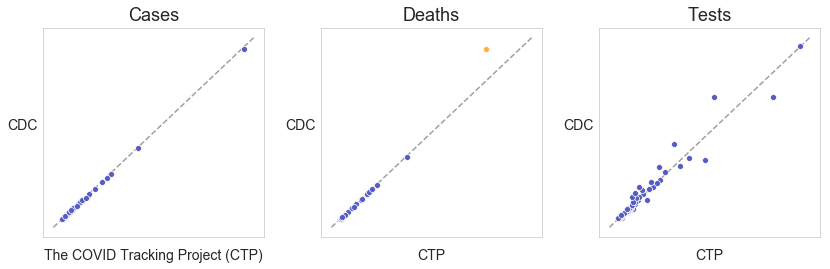

In [14]:
# plot all 3 together

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
fig.tight_layout(pad=3.0)

def plot_gray_yx(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0, linestyle='--', color='gray')
    
    # remove gridlines!
    ax.grid(False)

# Case counts

ax=axes[0]
sns.scatterplot(x='ctp_total_cases', y='cdc_total_cases', data=full_merged_df, ax=ax, color='#585bc1')
ax.set_ylabel('CDC', fontsize=14, rotation=0, labelpad=14)
ax.set_xlabel('The COVID Tracking Project (CTP)', fontsize=14)
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.set_title('Cases', fontsize=18, pad=8)
plot_gray_yx(ax)

# Death counts

ax = axes[1]
sns.scatterplot(x='ctp_total_death', y='cdc_total_death', data=full_merged_df, ax=ax, color='#585bc1')
# do a 2nd scatter plot on top, make the NY deaths dot in orange
sns.scatterplot(x='ctp_total_death', y='cdc_total_death',
                data=full_merged_df.loc[full_merged_df.index == 'NY'], ax=ax, color="#ffad4a")
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.set_ylabel('CDC', fontsize=14, rotation=0, labelpad=14)
ax.set_xlabel('CTP', fontsize=14)
ax.set_title('Deaths', fontsize=18, pad=8)
plot_gray_yx(ax)

# Testing counts

ax = axes[2]
sns.scatterplot(x='ctp_total_tests_for_analysis', y='cdc_total_tests', data=full_merged_df, ax=ax,
                color='#585bc1')
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.set_ylabel('CDC', fontsize=14, rotation=0, labelpad=14)
ax.set_xlabel('CTP', fontsize=14)
ax.set_title('Tests', fontsize=18, pad=8)
plot_gray_yx(ax)

plt.savefig("cases_deaths_testing_scatterplots.png", dpi=200, bbox_inches = "tight")

# Make basic state-level summary tables, one per state

In [15]:
# make state-level tables
for state in full_merged_df.index:
    row = full_merged_df.loc[state]
    positive_range = cdc.loc[cdc.state == state].iloc[0].cdc_percent_positive_range

    data_types = [row.jurisdiction, 'Cases', 'Deaths', 'Tests']
    cases_percent_diff_str = '%d%%' % round((row.cdc_total_cases-row.ctp_total_cases)/row.ctp_total_cases*100)
    deaths_percent_diff_str = '%d%%' % round((row.cdc_total_death-row.ctp_total_death)/row.ctp_total_death*100)
    tests_percent_diff_str = '%d%%' % round(row.test_count_percent_diff*100)
    data = {
        row.jurisdiction: ['State', 'CDC', '% Difference'],
        'Cases': [int(row.ctp_total_cases), int(row.cdc_total_cases), cases_percent_diff_str
                  ],
        'Deaths': [int(row.ctp_total_death), int(row.cdc_total_death), deaths_percent_diff_str
                  ],
        'Tests': [int(row.ctp_total_tests_for_analysis), int(row.cdc_total_tests), tests_percent_diff_str],
    }

    pd.DataFrame(data).to_csv('states/%s.csv' % state, index=False)

# Specimens vs people counts ratios, for states that report both

In [16]:
# These states report both 
states = ['FL', 'ME', 'NV', 'VA']
subset_df = ctp_514_test_overrides.loc[ctp_514_test_overrides.state.isin(states)].copy()
subset_df['percent_more_specimens'] = (subset_df.total_tests_specimens/subset_df.total_tests_people - 1)*100
subset_df

,date,state,total_tests_specimens,total_tests_people,total_tests_unclear,percent_more_specimens
9,20200514,FL,691653.0,609574.0,NaN,13.464977
21,20200514,ME,33035.0,28357.0,NaN,16.496809
33,20200514,NV,82993.0,69484.0,NaN,19.441886
45,20200514,VA,185551.0,165486.0,NaN,12.124893


In [17]:
# Get some ratio counts
specimens_people_df = ctp_514_test_overrides.loc[ctp_514_test_overrides.state.isin(states)].copy()[
    ['state', 'total_tests_specimens', 'total_tests_people']
]
specimens_people_df['ratio'] = specimens_people_df.total_tests_specimens/specimens_people_df.total_tests_people
specimens_people_df = specimens_people_df.set_index(['state'])
specimens_people_df.loc['Total'] = [
    sum(specimens_people_df.total_tests_specimens),
    sum(specimens_people_df.total_tests_people),
    np.mean(sum(specimens_people_df.total_tests_specimens)/sum(specimens_people_df.total_tests_people))
]
specimens_people_df

,total_tests_specimens,total_tests_people,ratio
state,,,
FL,691653.0,609574.0,1.134650
ME,33035.0,28357.0,1.164968
NV,82993.0,69484.0,1.194419
VA,185551.0,165486.0,1.121249
Total,993232.0,872901.0,1.137852


In [18]:
# alt ratio: average the individual ratios for each state
alt_ratio = np.mean(specimens_people_df.ratio)
alt_ratio

1.1506274946824986

# Plotting specimens vs people for the 4 states that report both

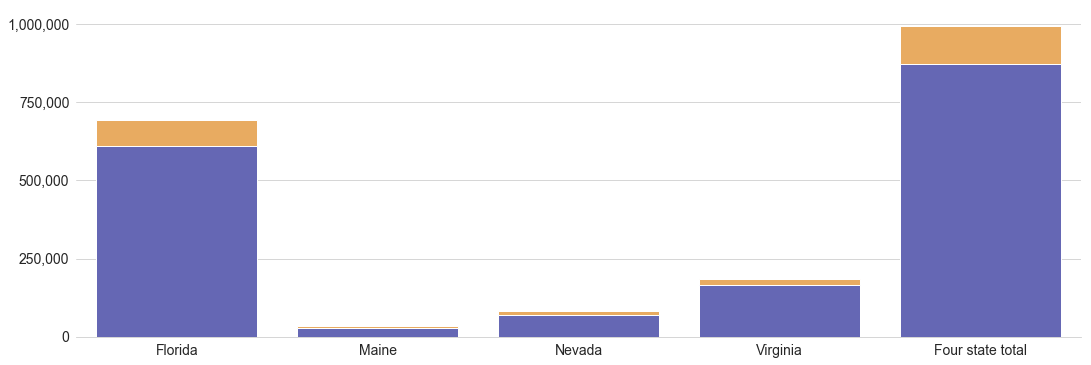

In [19]:
plt.figure(figsize=(18,6))

sns.barplot(x=specimens_people_df.index, y='total_tests_specimens', data=specimens_people_df, color="#ffad4a")
ax=sns.barplot(
    x=specimens_people_df.index, y='total_tests_people', data=specimens_people_df,
    color='#585bc1')

sns.despine(ax=ax, left=True)
labels = ['Florida', 'Maine', 'Nevada', 'Virginia', 'Four state total']
ax.set_xticklabels(labels=labels, fontsize=14)
ax.set_yticklabels(ax.get_yticks(), size=14)
ax.set_xlabel('')
ax.set_ylabel('')
ax.yaxis.set_major_locator(ticker.MultipleLocator(250000))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.savefig("people_vs_specimens.png", dpi=100, bbox_inches = "tight")